In [2]:
import os
import time
import logging
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Set up logging
log_dir = '/kaggle/working/FinalLogs'
os.makedirs(log_dir, exist_ok=True)
log_file = os.path.join(log_dir, 'vit_model_training.log')
logging.basicConfig(
    filename=log_file,
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)

class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

def create_vit_model(
    input_shape=(128, 128, 3),
    patch_size=16,
    num_patches=64,
    projection_dim=64,
    transformer_layers=8,
    num_heads=4,
    transformer_units=[128, 64],
    mlp_head_units=[256, 128],
    dropout_rate=0.3
):
    inputs = layers.Input(shape=input_shape)
    
    # Create patches
    patches = Patches(patch_size)(inputs)
    
    # Encode patches
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block
    for _ in range(transformer_layers):
        # Layer normalization 1
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        
        # Multi-head attention
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=dropout_rate
        )(x1, x1)
        
        # Skip connection 1
        x2 = layers.Add()([attention_output, encoded_patches])
        
        # Layer normalization 2
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        
        # MLP
        x3 = layers.Dense(transformer_units[0], activation=tf.nn.gelu)(x3)
        x3 = layers.Dropout(dropout_rate)(x3)
        x3 = layers.Dense(transformer_units[1], activation=tf.nn.gelu)(x3)
        x3 = layers.Dropout(dropout_rate)(x3)
        
        # Skip connection 2
        encoded_patches = layers.Add()([x3, x2])

    # Layer normalization
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    
    # Global average pooling
    representation = layers.GlobalAveragePooling1D()(representation)
    
    # MLP head
    features = layers.Dense(mlp_head_units[0], activation=tf.nn.gelu)(representation)
    features = layers.Dropout(dropout_rate)(features)
    features = layers.Dense(mlp_head_units[1], activation=tf.nn.gelu)(features)
    features = layers.Dropout(dropout_rate)(features)
    
    # Classification head
    outputs = layers.Dense(1, activation="sigmoid")(features)

    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

def train_model(model, train_generator, validation_generator, epochs=30):
    optimizer = tf.keras.optimizers.AdamW(
        learning_rate=3e-4,
        weight_decay=1e-4
    )
    
    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=0.1),
        metrics=["accuracy"],
    )
    
    callbacks = [
        keras.callbacks.EarlyStopping(
            monitor="val_loss",
            patience=5,
            restore_best_weights=True
        ),
        keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss",
            factor=0.2,
            patience=3,
            min_lr=1e-6
        ),
        keras.callbacks.ModelCheckpoint(
            'best_vit_model.keras',
            monitor="val_loss",
            save_best_only=True
        ),
        keras.callbacks.CSVLogger(
            os.path.join(log_dir, 'vit_training.csv')
        )
    ]
    
    history = model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=epochs,
        callbacks=callbacks,
        verbose=1  # This ensures that epoch-wise progress is displayed
    )
    
    return history


# Data augmentation setup
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Data generators
train_generator = train_datagen.flow_from_directory(
    '/kaggle/input/chest-x-ray-images/FinalData/train',
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    '/kaggle/input/chest-x-ray-images/FinalData/val',
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    '/kaggle/input/chest-x-ray-images/FinalData/test',
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary'
)

# Create and train model
vit_model = create_vit_model()
start_time = time.time()
history = train_model(vit_model, train_generator, validation_generator)
execution_time = time.time() - start_time

# Evaluate model
y_true = validation_generator.classes
y_pred = (vit_model.predict(validation_generator) > 0.5).astype("int32")

# Compute metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

# Log and print results
logging.info(f'ViT Model - Accuracy: {accuracy:.4f}')
logging.info(f'ViT Model - Precision: {precision:.4f}')
logging.info(f'ViT Model - Recall: {recall:.4f}')
logging.info(f'ViT Model - F1-score: {f1:.4f}')
logging.info(f'ViT Model - Execution Time: {execution_time:.2f} seconds')

print(f"ViT Model - Accuracy: {accuracy:.4f}")
print(f"ViT Model - Precision: {precision:.4f}")
print(f"ViT Model - Recall: {recall:.4f}")
print(f"ViT Model - F1-score: {f1:.4f}")
print(f"ViT Model - Execution Time: {execution_time:.2f} seconds")

Found 13830 images belonging to 2 classes.
Found 166 images belonging to 2 classes.
Found 2096 images belonging to 2 classes.
Epoch 1/30


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1732540211.008277      97 service.cc:145] XLA service 0x7d4cac001790 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732540211.008348      97 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1732540211.008354      97 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1732540246.652302     155 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_323', 256 bytes spill stores, 256 bytes spill loads



  1/433 ━━━━━━━━━━━━━━━━━━━━ 11:01:22 92s/step - accuracy: 0.7812 - loss: 0.6042

I0000 00:00:1732540277.528048      97 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


426/433 ━━━━━━━━━━━━━━━━━━━━ 3s 434ms/step - accuracy: 0.7145 - loss: 0.6242

I0000 00:00:1732540496.464206     185 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_323', 256 bytes spill stores, 256 bytes spill loads



433/433 ━━━━━━━━━━━━━━━━━━━━ 351s 601ms/step - accuracy: 0.7145 - loss: 0.6240 - val_accuracy: 0.7048 - val_loss: 0.6073 - learning_rate: 3.0000e-04
Epoch 2/30
433/433 ━━━━━━━━━━━━━━━━━━━━ 127s 288ms/step - accuracy: 0.7135 - loss: 0.5992 - val_accuracy: 0.8012 - val_loss: 0.5495 - learning_rate: 3.0000e-04
Epoch 3/30
433/433 ━━━━━━━━━━━━━━━━━━━━ 125s 285ms/step - accuracy: 0.7257 - loss: 0.5848 - val_accuracy: 0.7410 - val_loss: 0.6061 - learning_rate: 3.0000e-04
Epoch 4/30
433/433 ━━━━━━━━━━━━━━━━━━━━ 126s 286ms/step - accuracy: 0.7365 - loss: 0.5737 - val_accuracy: 0.7108 - val_loss: 0.6171 - learning_rate: 3.0000e-04
Epoch 5/30
433/433 ━━━━━━━━━━━━━━━━━━━━ 128s 290ms/step - accuracy: 0.7361 - loss: 0.5684 - val_accuracy: 0.7831 - val_loss: 0.5344 - learning_rate: 3.0000e-04
Epoch 6/30
433/433 ━━━━━━━━━━━━━━━━━━━━ 126s 287ms/step - accuracy: 0.7386 - loss: 0.5628 - val_accuracy: 0.7590 - val_loss: 0.5722 - learning_rate: 3.0000e-04
Epoch 7/30
433/433 ━━━━━━━━━━━━━━━━━━━━ 126s 288ms/

2024-11-25 14:12:38,172 - INFO - ViT Model - Accuracy: 0.6265
2024-11-25 14:12:38,173 - INFO - ViT Model - Precision: 0.6794
2024-11-25 14:12:38,174 - INFO - ViT Model - Recall: 0.8165
2024-11-25 14:12:38,175 - INFO - ViT Model - F1-score: 0.7417
2024-11-25 14:12:38,176 - INFO - ViT Model - Execution Time: 3765.57 seconds


ViT Model - Accuracy: 0.6265
ViT Model - Precision: 0.6794
ViT Model - Recall: 0.8165
ViT Model - F1-score: 0.7417
ViT Model - Execution Time: 3765.57 seconds


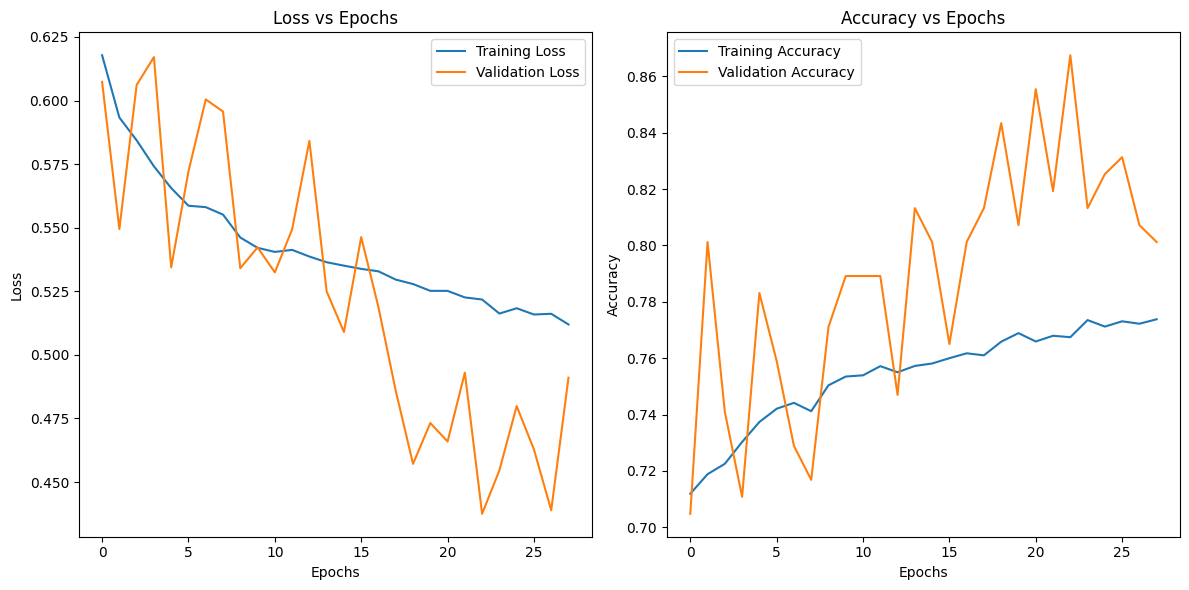

In [4]:
import matplotlib.pyplot as plt

def plot_performance(history):
    # Extracting the loss and accuracy values
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    
    # Plotting the loss
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plotting the accuracy
    plt.subplot(1, 2, 2)
    plt.plot(accuracy, label='Training Accuracy')
    plt.plot(val_accuracy, label='Validation Accuracy')
    plt.title('Accuracy vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Display the plots
    plt.tight_layout()
    plt.show()

# After training the model, call this function
plot_performance(history)
